The code and solutions for parts one and two are below.

For part 1, we find that at time=20, all three methods do fairly well at both preserving the energy and provinging accurate solutions. Now they do not preserve the energy exactly. Perhaps this is because of us needing to estimate the initial conditions. We see that C is the best at preserving energy, followed by A and the B. If we increase the time step to 200, the energy grows larger and part B no longer follows the true solution but becomes unruly with off the chart energy. For A and C the energy grows more slowly, For A, the energy triples at t=20000 and C, the energy doubles at t=20000. We thus find, C is the best at preserving energy, but A is pretty close, while B is horrible.

For Part 2, we see our solutions each stay close to zero until $t=\frac{1}{\delta}$ where they shoot up quicky to the equilibrium at one. Zooming in close to the solution at one does not show any squiggles near 1 like we saw in class when using the matlab ode solver.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from tqdm import tqdm


def euler_step(y, h, f):
    return y + h * f(y)

def symplectic_euler_step(y, h, f):
    p, q = y
    q_next = q + h * p
    p_next = p - h * np.sin(q_next)
    return np.array([p_next, q_next])
    
def modified_euler_step(y, h, f):
    k1 = h * f(y)
    k2 = h * f(y + k1)
    return y + k1/2+k2/2

def implicit_midpoint_step(y, h, f):
    def g(y_star):
        return y-y_star + h * f((y+y_star)/2)
    result = root(g, y)
    return result.x
    
def Trapezoidal_step(y, h, f):
    def g2(y_star):
        return y-y_star + 1/2*h * (f(y)+f(y_star))
    result = root(g2, y)
    return result.x

def BDF_step(y, y1, h, f):
    def g2(y_star):
        return 4/3*y-y_star -1/3*y1+ 2/3*h * f(y_star)
    result = root(g2, y)
    
    return result.x

def solve(f, y0, t0, tf, h, method):
    
    times = np.arange(t0, tf, h)
    ys = np.zeros((len(times), len(y0)))
    ys[0,:] = y0
    if (method=='Explicit Euler'):
        for i in tqdm(range(len(times[:-1]))):
            ys[i+1,:] = euler_step(ys[i,:], h, f)
    elif (method=='Symplectic Euler'):
        for i in tqdm(range(len(times[:-1]))):
            ys[i+1,:] = symplectic_euler_step(ys[i,:], h, f)
    elif (method=='Modified Euler'):
        for i in tqdm(range(len(times[:-1]))):
            ys[i+1,:] = modified_euler_step(ys[i,:], h, f)
    elif (method=='Implicit Midpoint'):
        for i in tqdm(range(len(times[:-1]))):
            ys[i+1,:] = implicit_midpoint_step(ys[i,:], h, f)
    elif (method=='Trapezoidal'):
        for i in tqdm(range(len(times[:-1]))):
            ys[i+1,:] = Trapezoidal_step(ys[i,:], h, f)
    elif (method=='BDF'):
        for i in tqdm(range(len(times[:-1]))):
            if (i==0):
                ys[i+1,:] = implicit_midpoint_step(ys[i,:], h, f)
            else:
                ys[i+1,:] = BDF_step(ys[i,:],ys[i-1,:], h, f)
    else:print('ERROR: Please set Method to Explicit Euler, Symplectic Euler, Modified Euler, Implicit Midpoint, Trapezoidal, or BDF.')

    return times, ys

def energy(y):
    p, q = y
    return p**2 / 2 + (1 - np.cos(q))

def MS(t0, tf, h, y0, f, g, method):
    times = np.arange(t0, tf, h)
    ys = np.zeros((len(times), len(y0)))
    ys[0,:] = y0
    ys[1,:]=solve(f, y0, t0, t0+2*h, h, 'Modified Euler')[1][-1]
    ys[2,:]=solve(f, y0, t0, t0+3*h, h,'Modified Euler')[1][-1]
    ys[3,:]=solve(f, y0, 0, t0+4*h, h,'Modified Euler')[1][-1]
    
    if (method=='A'):
        for i in tqdm(range(3, len(times[:-1]))):
            ys[i+1,:] = 2*ys[i,:]-ys[i-1,:] + (h**2) * ((7/6) * g(ys[i,:]) - (5/12)*g(ys[i-1,:])+(1/3)*g(ys[i-2,:])-(1/12) *g(ys[i-3,:]))
    elif (method=='B'):
        for i in tqdm(range(3, len(times[:-1]))):
            ys[i+1,:] = 2*ys[i-1,:]-ys[i-3,:] + (h**2) * ((4/3) * g(ys[i,:]) + (4/3)*g(ys[i-1,:])+(4/3)*g(ys[i-2,:]))
    elif (method=='C'):
        for i in tqdm(range(3, len(times[:-1]))):
            ys[i+1,:] = 2*ys[i,:]-2*ys[i-1,:]+2*ys[i-2,:]-ys[i-3,:] + (h**2) * ((7/6) * g(ys[i,:]) - (1/3)*g(ys[i-1,:])+(7/6)*g(ys[i-2,:]))
    else:
        print('ERROR: Please set Method to A, B , or C.')

    return times, ys

def plot(times, ys):
    fig, axs = plt.subplots(1, 2, figsize=(10,5))

    axs[0].plot(ys[:,1], ys[:,0])
    axs[0].set_title("Phase plane")
    axs[0].set_xlabel("q")
    axs[0].set_ylabel("p")
    
    axs[1].plot(times, energy(ys.T))
    axs[1].set_title("Energy")
    axs[1].set_xlabel("t")
    axs[1].set_ylabel("E")


100%|██████████| 246/246 [00:00<00:00, 19708.49it/s]


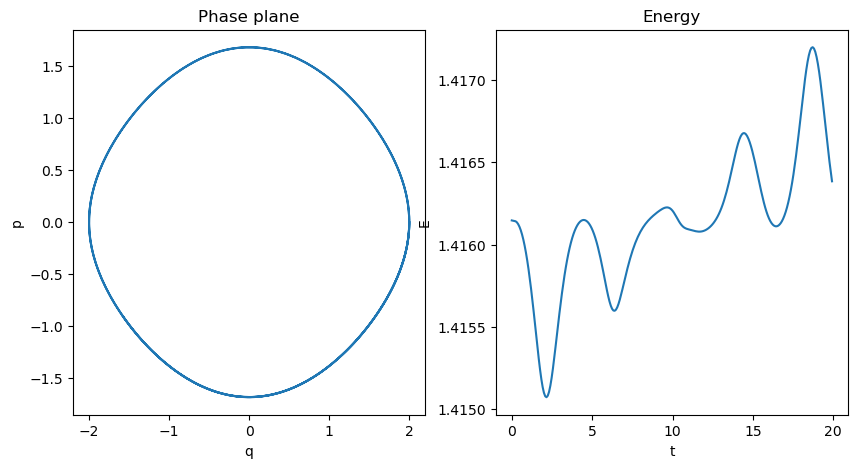

In [19]:
#Problem 1-A
def f(y):
    p, q = y
    return np.array([-np.sin(q), p])

def g(y):
    p, q = y
    return np.array([-np.cos(q)*p, -np.sin(q)])

t0=0
tf=20
y0 = np.array([0, 2])
h=0.08
times, ys = MS(t0, tf, h, y0, f, g, 'A')
plot(times, ys)

100%|██████████| 246/246 [00:00<00:00, 19003.22it/s]


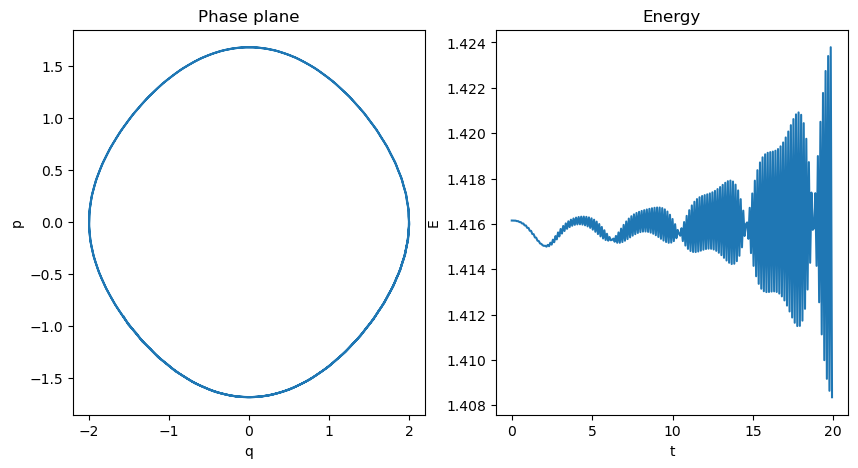

In [20]:
#Problem 1-B
times, ys = MS(t0, tf, h, y0, f, g, 'B')
plot(times, ys)

100%|██████████| 246/246 [00:00<00:00, 19727.33it/s]


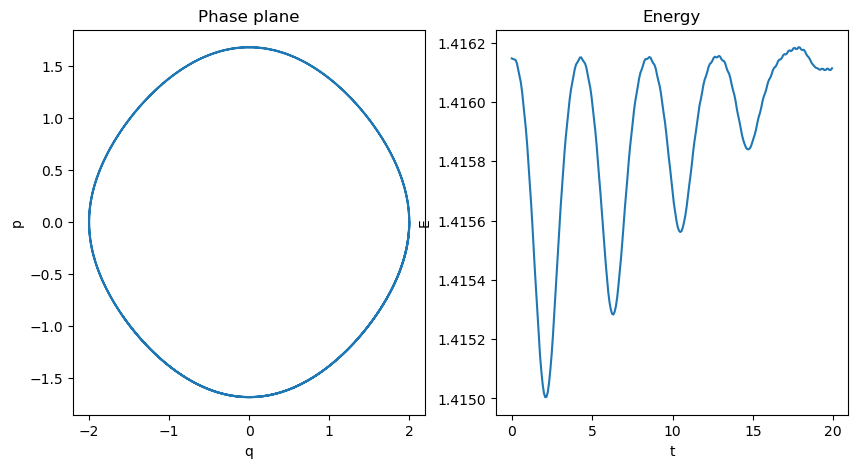

In [21]:
#Problem 1-C
times, ys = MS(t0, tf, h, y0, f, g, 'C')
plot(times, ys)

100%|██████████| 19999999/19999999 [27:37<00:00, 12069.07it/s]


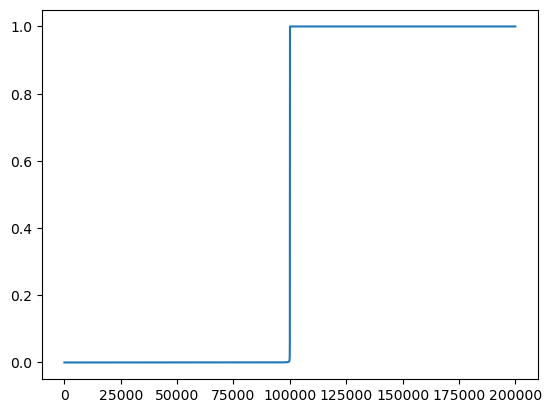

In [5]:

#Problem 2-A
def f1(y):
    return y**2-y**3

t0=0
delta = np.array([1e-5])
tf=2/delta
h=0.01
times, ys=solve(f1, delta, t0, tf, h,'Implicit Midpoint')
plt.plot(times, ys)



100%|██████████| 19999999/19999999 [27:53<00:00, 11949.18it/s]


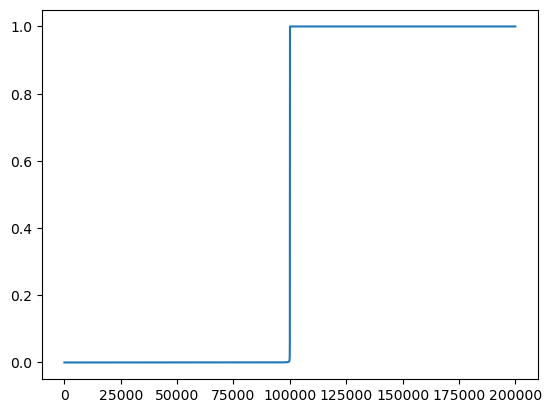

In [6]:
#Problem 2-B
times, ys=solve(f1, delta, t0, tf, h,'Trapezoidal')
plt.plot(times, ys)

100%|██████████| 19999999/19999999 [33:59<00:00, 9805.30it/s] 


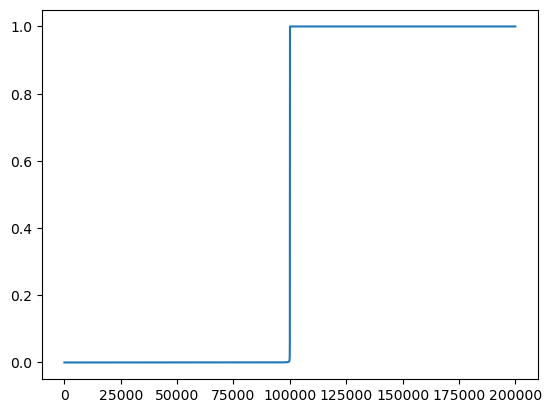

In [11]:
#Problem 2-C
t0=0
delta = np.array([1e-5])
tf=2/delta
h=0.01
times, ys=solve(f1, delta, t0, tf, h,'BDF')
plt.plot(times, ys)